# TASK_10
## Song recommendation based on facial expression
### Done by :- Vatsavai Vinay Varma 

# Import Libraries

In [1]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.8.0
Num GPUs Available:  0


In [3]:
train_dir = "D:\\lgm\\images\\images\\train"
test_dir ="D:\\lgm\\images\\images\\validation"

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3993      436  4103   7164     4982  4938      3205
      angry  disgust  fear  happy  neutral   sad  surprise
test    960      111  1018   1825     1216  1139       797


# Data Visualization

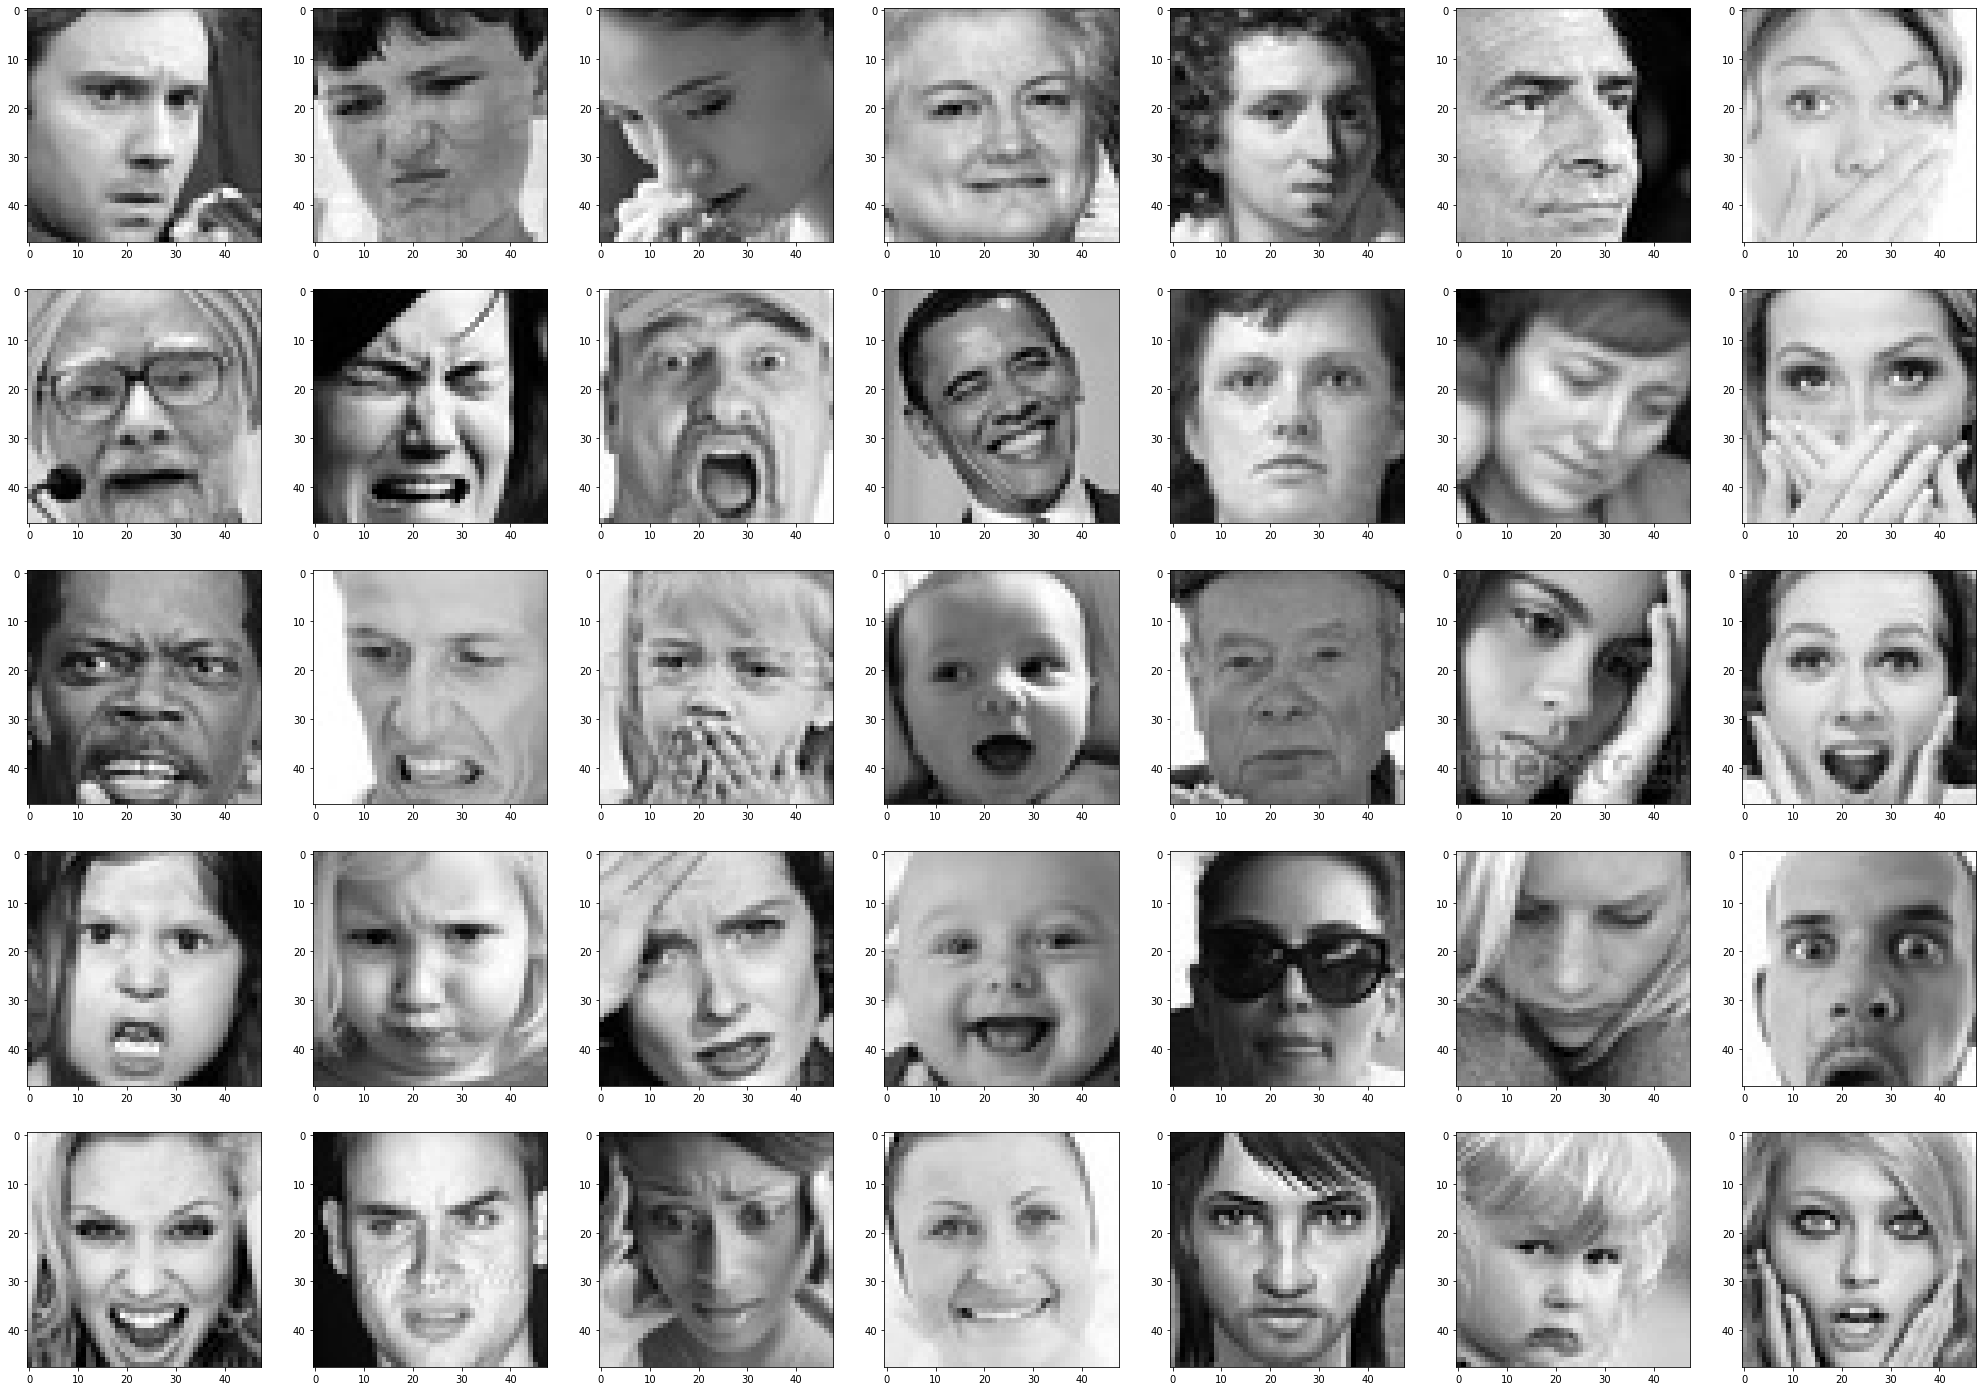

In [5]:
from skimage.io import imread
train_dir = "D:\\lgm\\images\\images\\train\\"
test_dir ="D:\\lgm\\images\\images\\validation\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

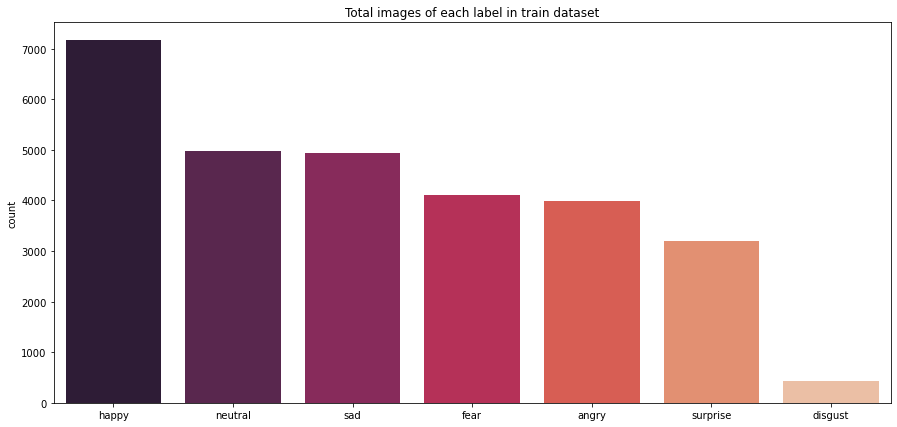

In [7]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="rocket", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()


C:\Users\vinnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


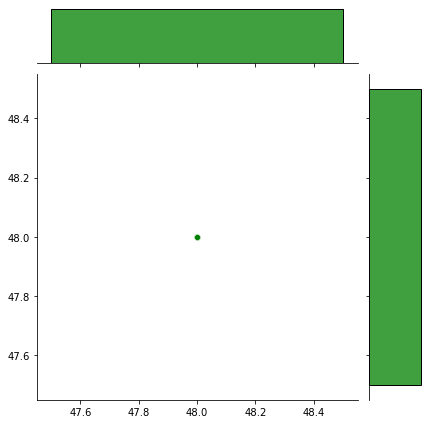

In [8]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='g')
plt.show()

# Data Preprocessing

In [9]:
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model creation

In [10]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

# Train the model

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001, 
                             decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
450/450 [==============================] - 947s 2s/step - loss: 1.8833 - accuracy: 0.2274 - val_loss: 2.3241 - val_accuracy: 0.2372
Epoch 2/20
450/450 [==============================] - 577s 1s/step - loss: 1.7977 - accuracy: 0.2477 - val_loss: 1.7777 - val_accuracy: 0.2893
Epoch 3/20
450/450 [==============================] - 864s 2s/step - loss: 1.7826 - accuracy: 0.2561 - val_loss: 1.6938 - val_accuracy: 0.3104
Epoch 4/20
450/450 [==============================] - 578s 1s/step - loss: 1.7627 - accuracy: 0.2719 - val_loss: 1.6555 - val_accuracy: 0.3366
Epoch 5/20
450/450 [==============================] - 712s 2s/step - loss: 1.7360 - accuracy: 0.2895 - val_loss: 1.6369 - val_accuracy: 0.3483
Epoch 6/20
450/450 [==============================] - 634s 1s/step - loss: 1.7075 - accuracy: 0.3099 - val_loss: 1.5647 - val_accuracy: 0.3909
Epoch 7/20
450/450 [==============================] - 571s 1s/step - loss: 1.6704 - accuracy: 0.3262 - val_loss: 1.5474 - val_accuracy: 0.4009

In [14]:
model.save("model.h5")

# Evaluate the model

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

111/111 [==============================] - 22s 199ms/step - loss: 1.2100 - accuracy: 0.5375
validation accuracy : 53.750354051589966%
validation loss : 1.210018515586853


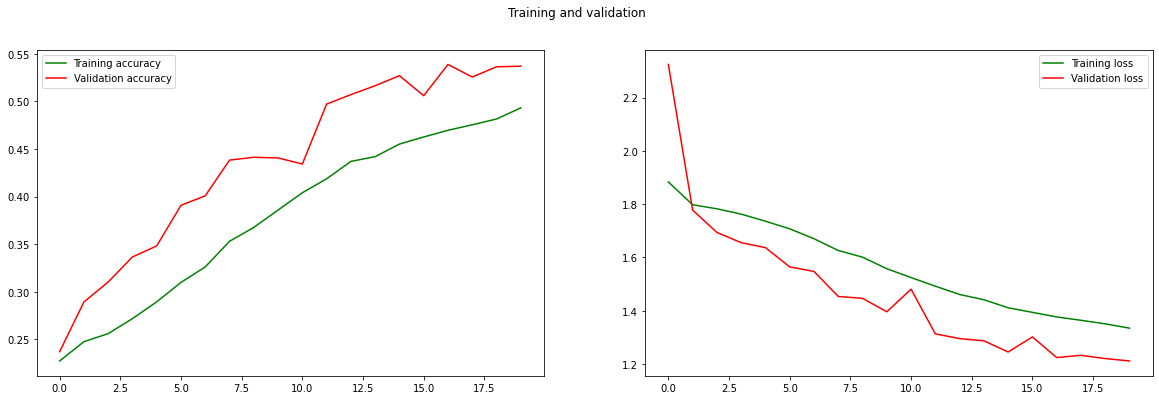

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

# confusion matrix

              precision    recall  f1-score   support

       angry       0.44      0.44      0.44       960
     disgust       1.00      0.01      0.02       111
        fear       0.39      0.18      0.25      1018
       happy       0.71      0.87      0.78      1825
     neutral       0.42      0.66      0.51      1216
         sad       0.50      0.18      0.26      1139
    surprise       0.56      0.75      0.64       797

    accuracy                           0.54      7066
   macro avg       0.57      0.44      0.41      7066
weighted avg       0.53      0.54      0.50      7066





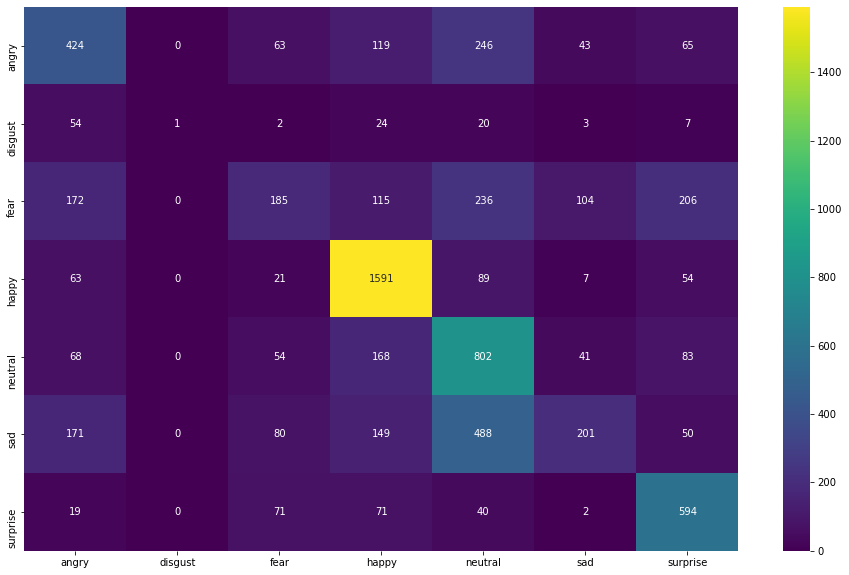

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

# Testing the model

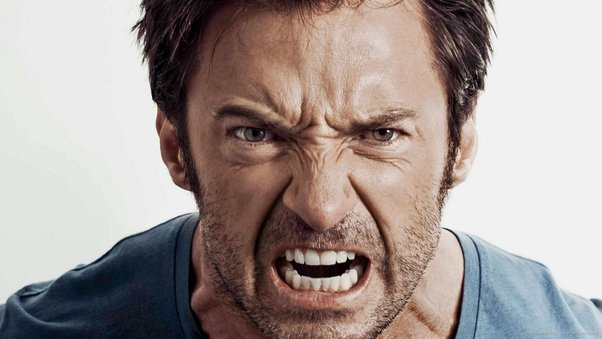

In [40]:
image = cv2.imread("C:\\Users\\vinnu\\Downloads\\angry man.jpEg")
from IPython.display import Image
Image(filename="C:\\Users\\vinnu\\Downloads\\angry man.jpeg")

In [41]:
import cv2
from tensorflow.python.keras.models import load_model
import os
model = tf.keras.models.load_model("model.h5",
    custom_objects={'Functional':tf.keras.models.Model})
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
img = image
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0
gray = gray.reshape(1,48,48,1)
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The expression is:",label)

  Angry   prediction rate is   0.38%
 Disgust  prediction rate is   0.03%
  Happy   prediction rate is   0.18%
   Sad    prediction rate is   0.24%
 Surprise prediction rate is   0.05%
 Neutral  prediction rate is   0.07%


 The expression is: Angry


# Song recommendation

In [42]:
if (label=='Angry'):
    path="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\ANGRY\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\ANGRY\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\DISGUST\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\DISGUST\\'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\HAPPY\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\HAPPY\\"+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\SAD\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\SAD\\"+ d,autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\SURPRISE\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\SURPRISE\\"+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\NEUTRAL\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename="C:\\Users\\vinnu\\OneDrive\\Desktop\\task10\\NEUTRAL\\"+ d,autoplay=True)
    display(audio)


Now Playing: [iSongs.info] 02 - Baga Baga.mp3
